# Introduction
The clustering algorithm requires parameters for DBSCAN as well as other temporal parameters. This notebook is used to test different parameters for the clustering algorithm.

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/DynCondPaper'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [3]:
def dist_vs_idx_dist(com_arr):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :] - com_arr[np.newaxis, :, :], axis=2)
    avg_dist_arr = np.zeros((sep_mat.shape[0]))
    avg_dist_sem_arr = np.zeros((sep_mat.shape[0]))
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr[i] = diag.mean()
        avg_dist_sem_arr[i] = stats.sem(diag)
    return avg_dist_arr, avg_dist_sem_arr
    

def sd_num(h5_data):
    ydict = yaml.safe_load(h5_data.attrs['RunConfig'])
    return ydict['rngSeed']

# Single snapshot clusters

number of estimated clusters : 10
number of thresholded clusters : 3


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

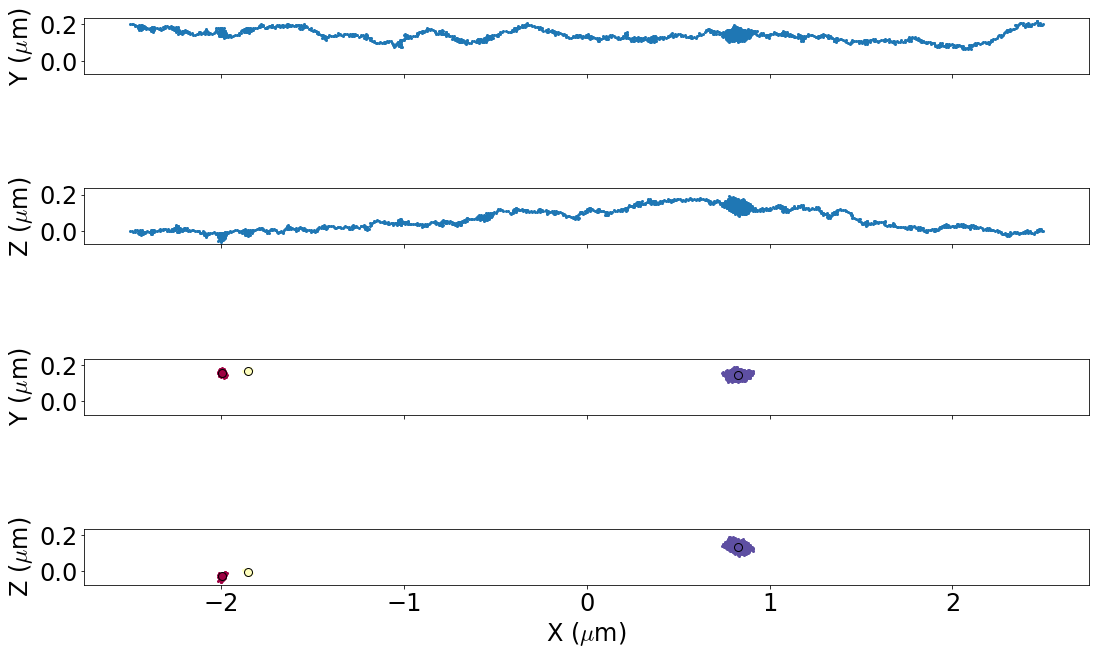

In [36]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s1/")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.020, min_samples=15)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)
   
  

number of estimated clusters : 7
number of thresholded clusters : 5


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

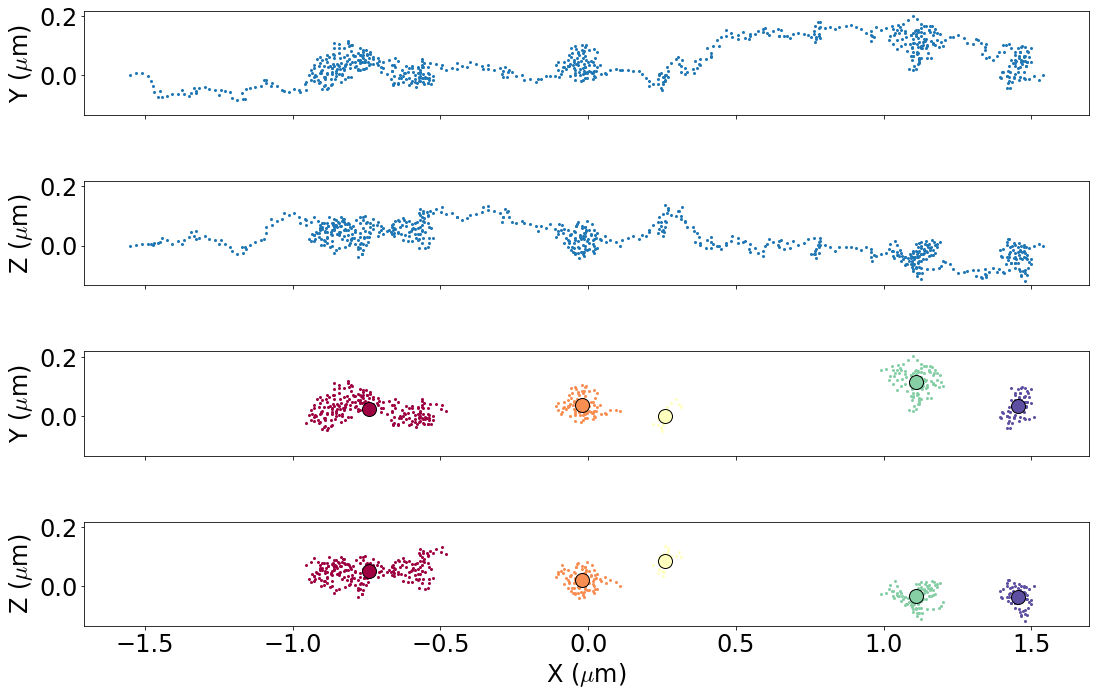

In [6]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

   
fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/cluster_analysis.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, 500], eps=.05, min_samples=12)
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,500], clust, cluster_centers, cluster_label_inds)
    

number of estimated clusters : 9
number of thresholded clusters : 5


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

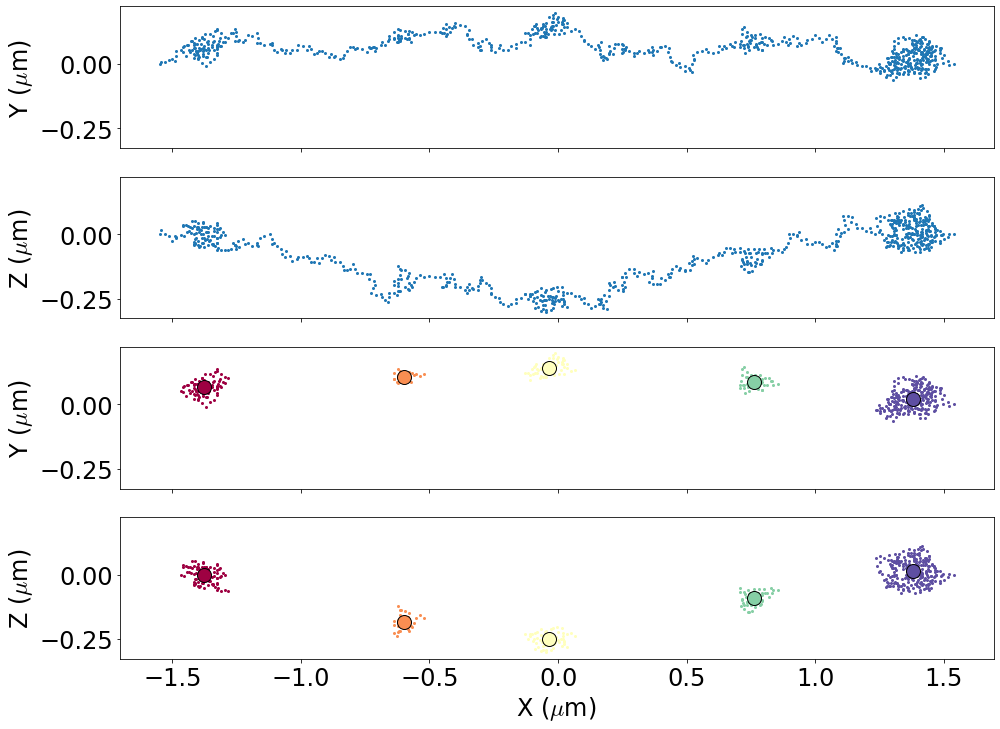

In [7]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.05, min_samples=12)
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



number of estimated clusters : 8
number of thresholded clusters : 2


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

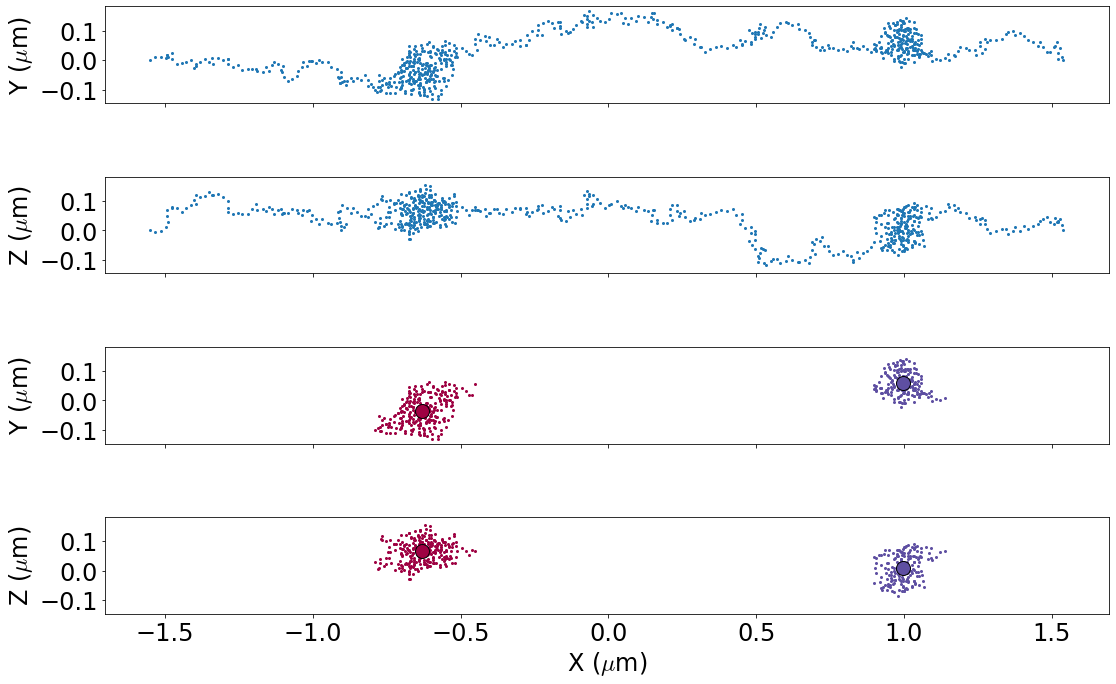

In [12]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1],eps=.05, min_samples=12)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



number of estimated clusters : 6
number of thresholded clusters : 4


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

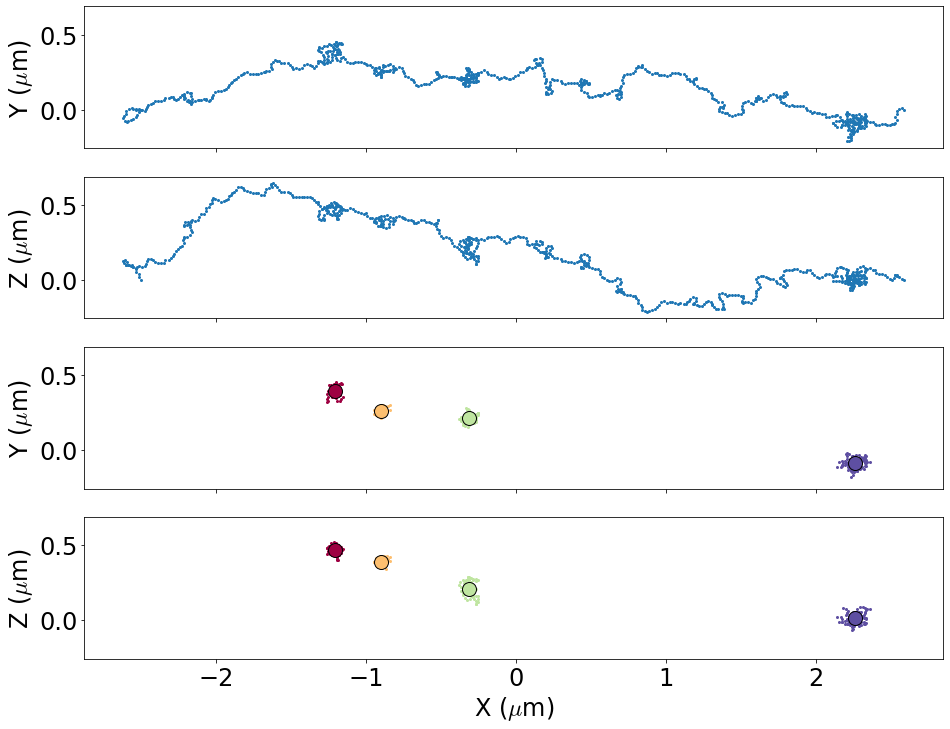

In [8]:
data_path = (
    ws_path / "22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s4")
ss_ind = 1
end_ind = 100
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.05, min_samples=12)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



number of estimated clusters : 7
number of thresholded clusters : 2


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

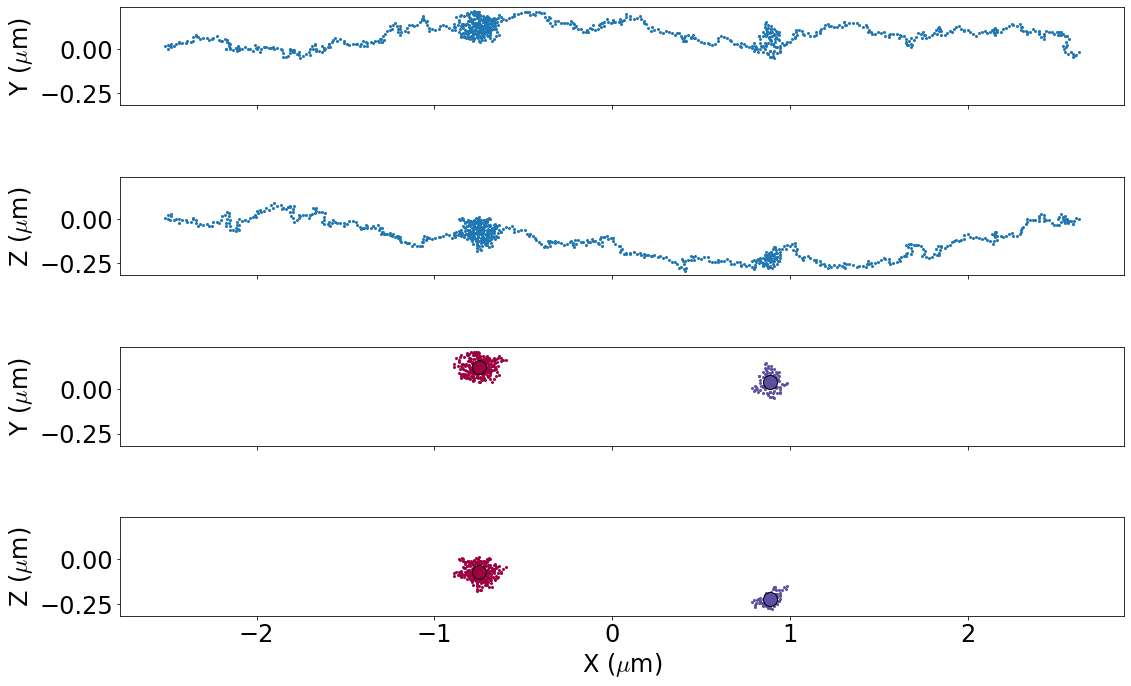

In [9]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.05, min_samples=12)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



# DBSCAN characterization

In [17]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s1/")

In [12]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s1/")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

# fig, axarr = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    X, Y = np.meshgrid(eps, min_sample)
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            # print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=12, verbose=False)
            clust_num_mat[i,j] = len(cluster_centers)
            if clust_num_mat[i,j] == 0:
                beads_in_clust_mat[i,j] = 0
                avg_bead_per_clust_mat[i,j] = 0
                continue
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])


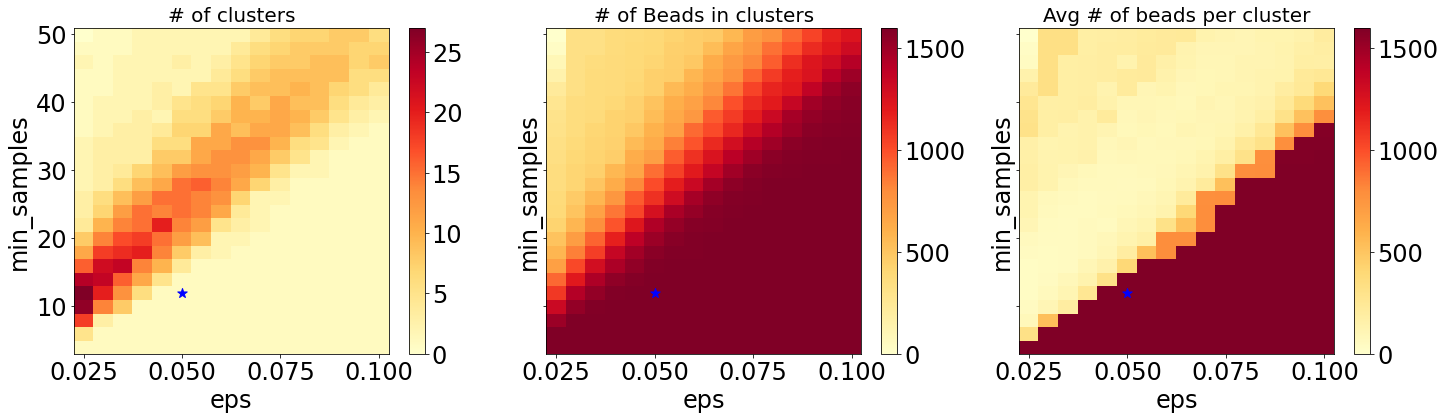

In [16]:
fig, axarr = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True)
plt.rcParams['pcolor.shading'] = 'auto'
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
for ax in axarr:
    _ = ax.scatter(.05, 12, marker='*', color='b', s=100)
    _ = ax.set_xlabel('eps')
    _ = ax.set_ylabel('min_samples')
    
            
   # cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



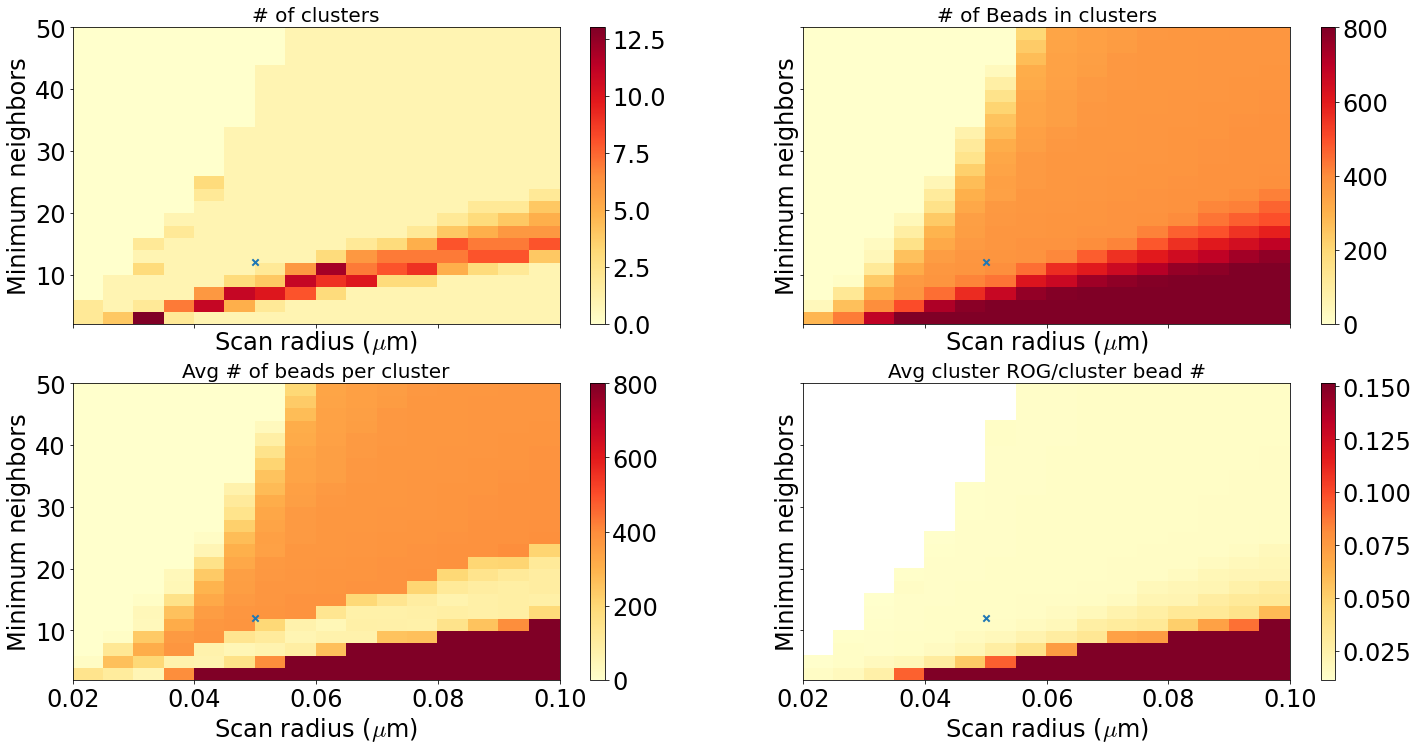

In [18]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    eps = np.arange(.025, .105, .005)
    min_sample = np.arange(4, 52, 2)
    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            # print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=12, verbose=False)
            clust_num_mat[i,j] = len(cluster_centers)
            if clust_num_mat[i,j] == 0:
                beads_in_clust_mat[i,j] = 0
                avg_bead_per_clust_mat[i,j] = 0
                avg_rog_mat[i,j] = np.nan
                continue
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])
            avg_rog_mat[i,j] = np.mean([ca.calc_rad_of_gyration(com_arr[cli,:,end_ind,np.newaxis])/np.cbrt(len(cli)) for cli in cluster_label_inds]) 

    
X, Y = np.meshgrid(eps-.0025, min_sample-1)
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, avg_rog_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title(f'Avg cluster ROG/cluster bead #')
for ax in axarr:
    _ = ax.scatter(.05, 12, s=40, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')



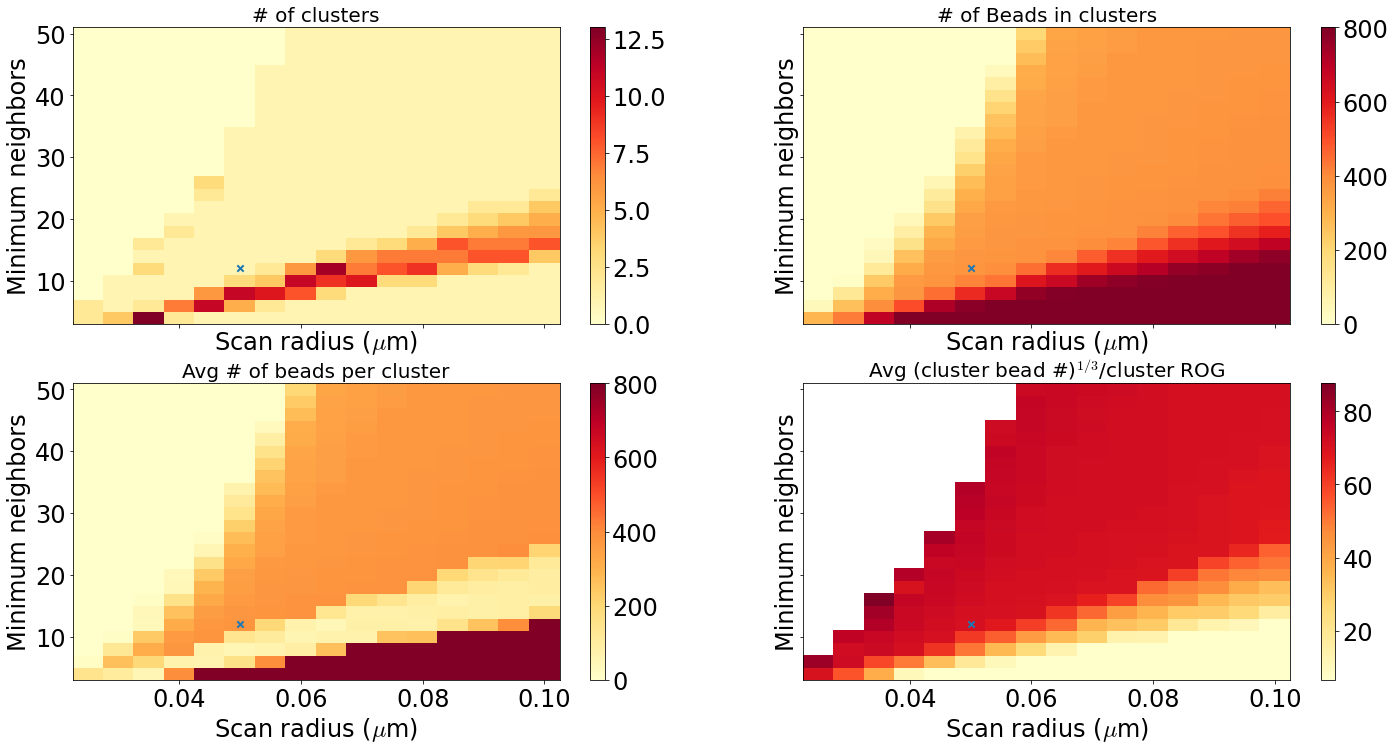

In [26]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulatvions/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()

X, Y = np.meshgrid(eps, min_sample)
plt.rcParams['pcolor.shading'] = 'auto'
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, 1./(avg_rog_mat.T))
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title('Avg (cluster bead #)$^{1/3}$/cluster ROG')
for ax in axarr:
    _ = ax.scatter(.05, 12, s=40, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')
            



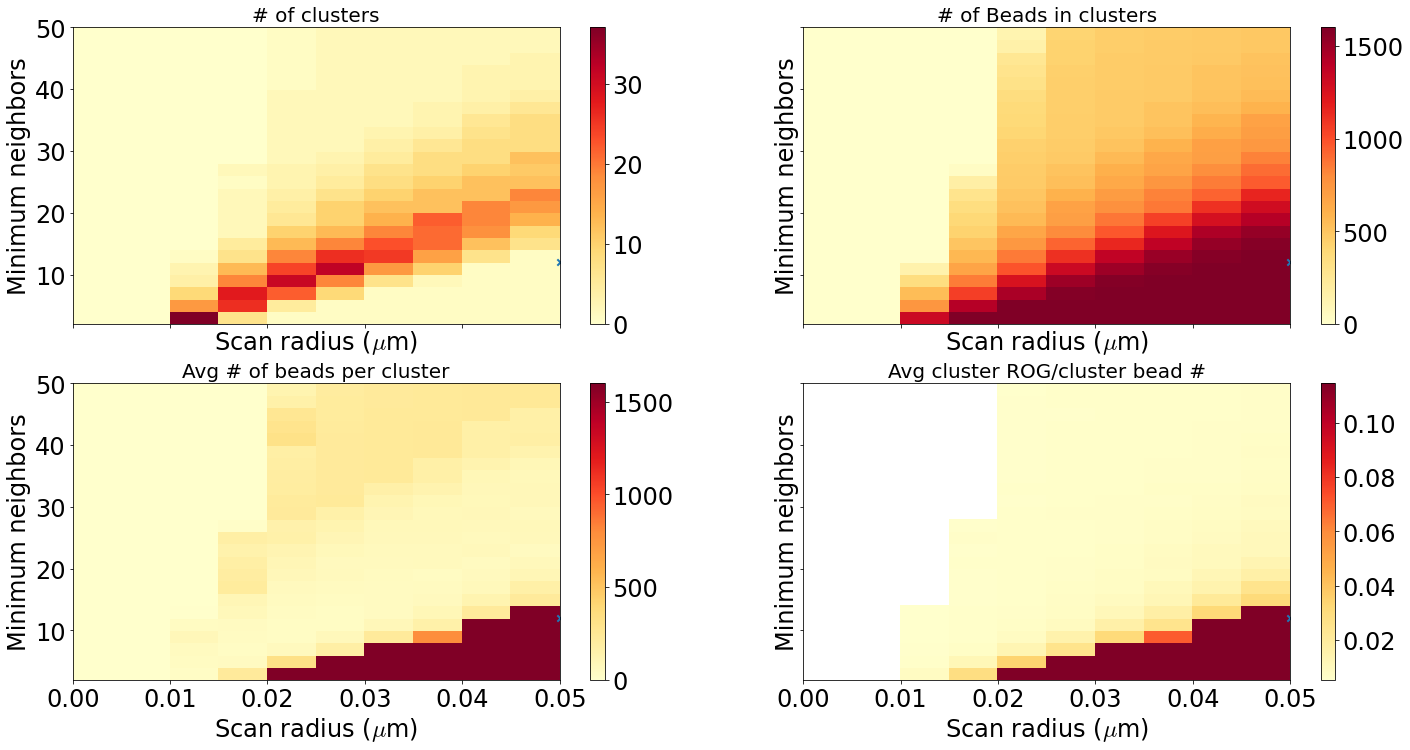

In [19]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s1/")
ss_ind = -500
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    eps = np.arange(.005, .055, .005)
    min_sample = np.arange(4, 52, 2)
    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            # print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=12, verbose=False)
            clust_num_mat[i,j] = len(cluster_centers)
            if clust_num_mat[i,j] == 0:
                beads_in_clust_mat[i,j] = 0
                avg_bead_per_clust_mat[i,j] = 0
                avg_rog_mat[i,j] = np.nan
                continue
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])
            avg_rog_mat[i,j] = np.mean([ca.calc_rad_of_gyration(com_arr[cli,:,end_ind,np.newaxis])/np.cbrt(len(cli)) for cli in cluster_label_inds]) 

    
X, Y = np.meshgrid(eps-.0025, min_sample-1)
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, avg_rog_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title(f'Avg cluster ROG/cluster bead #')
for ax in axarr:
    _ = ax.scatter(.05, 12, s=40, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')



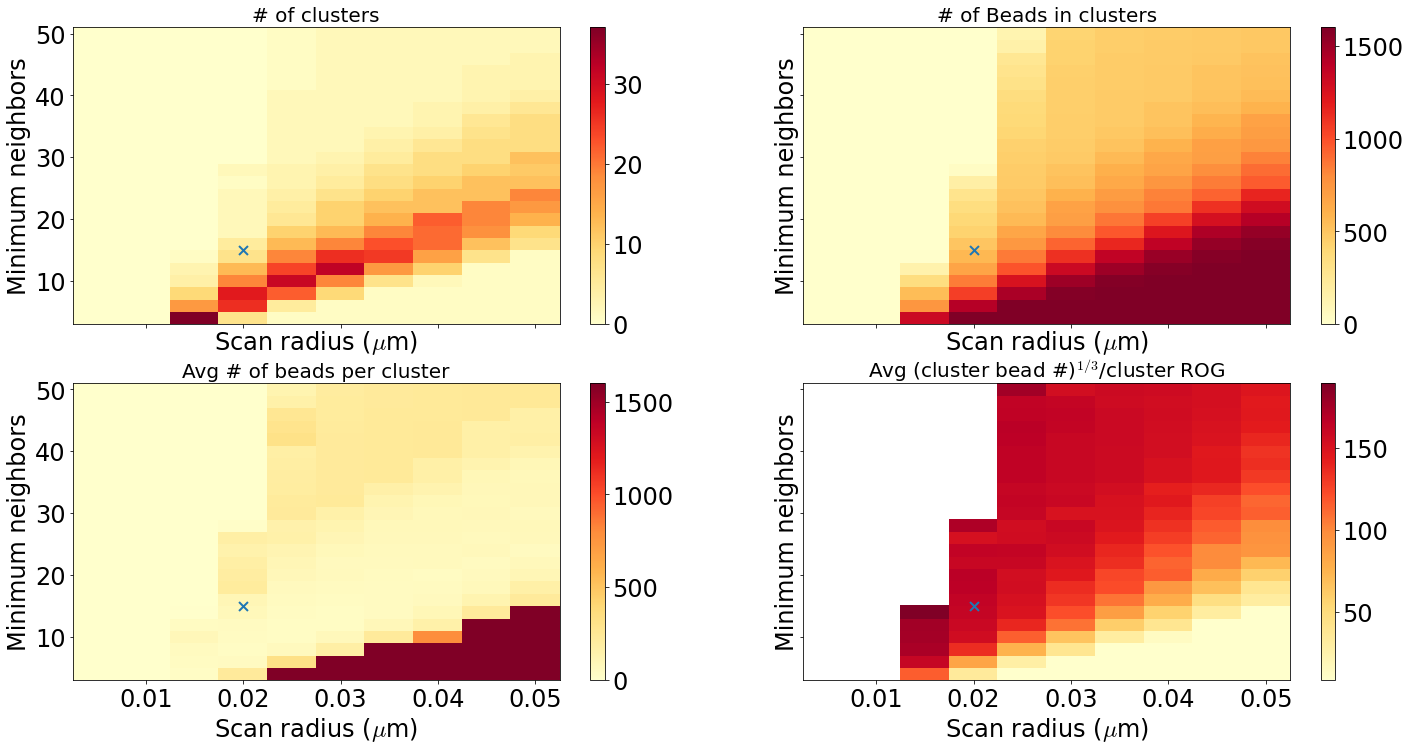

In [37]:
fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()

X, Y = np.meshgrid(eps, min_sample)
plt.rcParams['pcolor.shading'] = 'auto'
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, 1./(avg_rog_mat.T))
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title('Avg (cluster bead #)$^{1/3}$/cluster ROG')
for ax in axarr:
    _ = ax.scatter(.02, 15, s=80, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')
            



# Clusters over time

30.661806344985962
0.30661806344985965


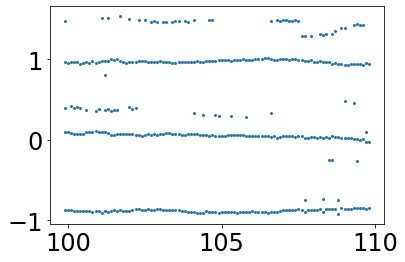

In [ ]:
data_path = (ceph_path /"21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1000
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(100):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 20:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

34.89495635032654
0.3489495635032654


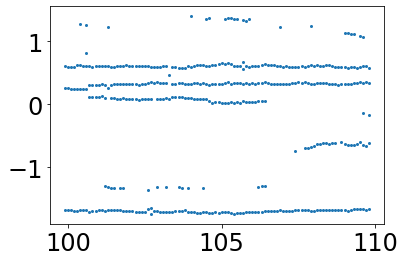

In [ ]:
data_path = (ceph_path /"21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/s6")
ss_ind = 600
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(1000):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 20:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


623.9818077087402
0.3119909038543701


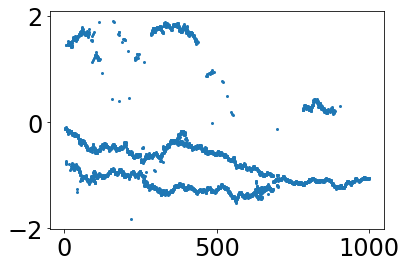

In [ ]:
data_path = (ceph_path /"22-01-06_aLchr1_scan8.12_line700_2xsticky_4umconf_ko.1-300/simulations/kod1/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(2000):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # Run OPTICS: min_sample=
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Center clustering in the time dimension

number of estimated clusters : 5


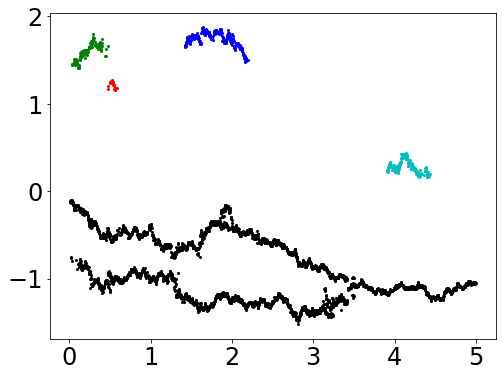

In [ ]:
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005
flat_time_arr = np.asarray(flat_time_arr)
time_space_clust_cent_arr = np.hstack((time_scale * flat_time_arr[:,np.newaxis], flat_clust_cent_arr))


_ = time_clust.fit(time_space_clust_cent_arr)
labels = time_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("number of estimated clusters : %d" % n_clusters_)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    n_members = np.where(labels == k)[0].size
    # print(np.where(labels == k)[0].size)
    if n_members < 5:
        continue
    
    #cluster_center = cluster_centers[k]
    _ = axarr.scatter(time_space_clust_cent_arr[my_members, 0], time_space_clust_cent_arr[my_members, 1], color=col)

#     _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
# for k, col in zip(range(n_



number of estimated clusters : 5


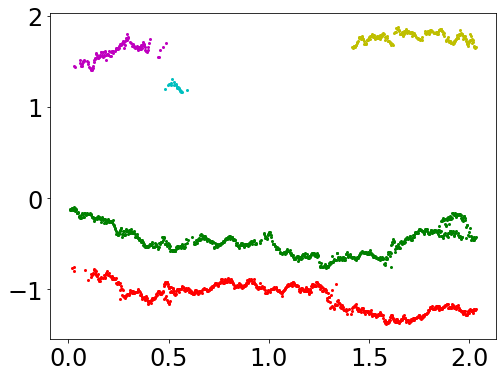

In [ ]:
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005
flat_time_arr = np.asarray(flat_time_arr)
time_space_clust_cent_arr = np.hstack((time_scale * flat_time_arr[:,np.newaxis], flat_clust_cent_arr))[:2000]


_ = time_clust.fit(time_space_clust_cent_arr)
labels = time_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("number of estimated clusters : %d" % n_clusters_)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    n_members = np.where(labels == k)[0].size
    # print(np.where(labels == k)[0].size)
    if n_members < 5:
        continue
    
    #cluster_center = cluster_centers[k]
    _ = axarr.scatter(time_space_clust_cent_arr[my_members, 0], time_space_clust_cent_arr[my_members, 1], color=col)

#     _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
# for k, col in zip(range(n_



743.3069474697113
0.37165347373485563


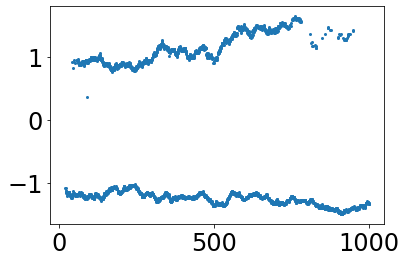

In [ ]:
data_path = (ceph_path /"22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.07/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

760.0616588592529
0.38003082942962646


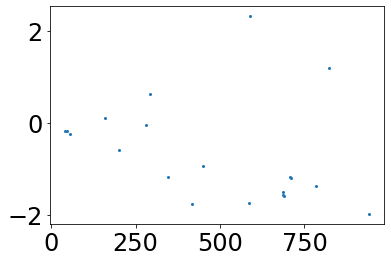

In [ ]:
data_path = (ceph_path /"22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.01/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        coms = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(coms)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50: # Threshold cluster size
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [coms[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

637.6565668582916
0.3188282834291458


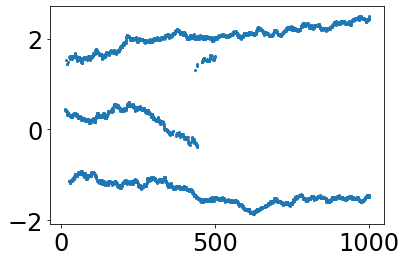

In [28]:
data_path = (ws_path / "22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s7")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        coms = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(coms)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50: # Threshold cluster size
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [coms[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Testing

  0%|          | 0/2000 [00:00<?, ?it/s]

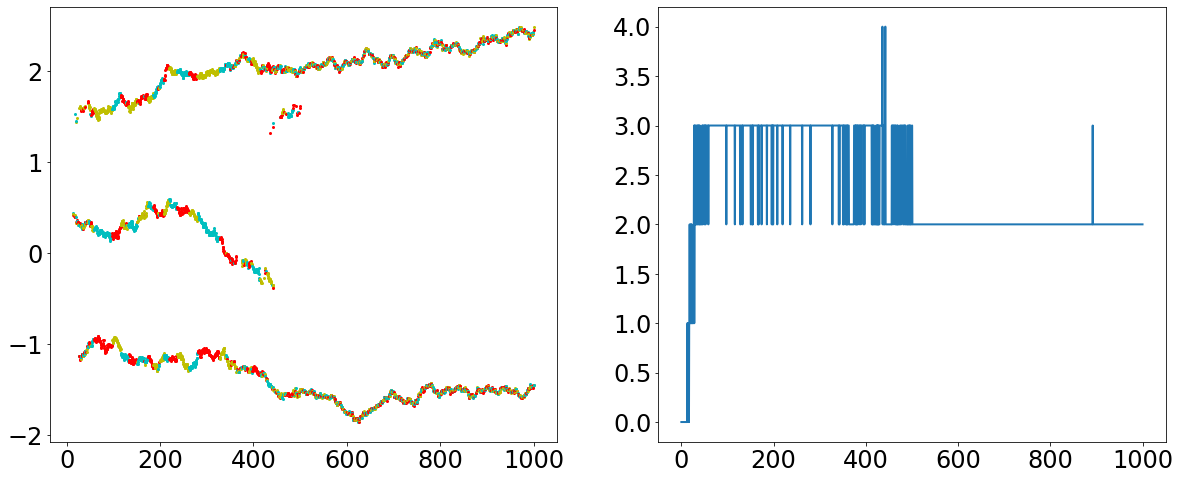

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(20, 8))

colors = cycle("rcy")
clust_num_arr = []
for c, clust_grp in tqdm(enumerate(cluster_center_lst), total=len(cluster_center_lst)):
    clust_num_arr += [len(clust_grp)]
    for (clust_cent, col) in zip(clust_grp,colors):
        _ = axarr[0].scatter(time_arr[c], clust_cent[0], color=col)
_ = axarr[1].plot(time_arr[:len(clust_num_arr)], clust_num_arr)
        

In [ ]:
clusters = [ [cluster[0]] for cluster in cluster_lst[100] if isinstance(cluster[0], np.ndarray)]
#print(clusters)
for cluster in tqdm(cluster_lst[100:], total = len(cluster_lst[100:])):
    for oc in clusters:
        if float(np.intersect1d(oc[-1], cluster[0]).size/len(oc[-1]))> .75:
            oc += [cluster[0]]


  0%|          | 0/1900 [00:00<?, ?it/s]